# Copyright Netherlands eScience Center <br>
** Function     : Lead/lag regression of climate patterns on atmospheric meridional energy transport (MERRA2,ERA-Interim,JRA55)** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2019.04.06 ** <br>
** Last Update  : 2019.04.06 ** <br>
Description     : <br>

Return Value    : NetCFD4 data file<br>
Dependencies    : os, time, numpy, netCDF4, sys, matplotlib, logging<br>
variables       : Meridional Energy Transport E [Tera-Watt] <br>
Caveat!!        : Spatial and temporal coverage<br>
                  Atmosphere<br>
                  ERA-Interim   1979 - 2016<br>
                  MERRA2        1980 - 2016<br>
                  JRA55         1979 - 2015<br>
                  Ocean<br>
                  GLORYS2V3     1993 - 2014<br>
                  ORAS4         1958 - 2014<br>
                  SODA3         1980 - 2015<br>
                  NEMO ORCA0083 1979 - 2012<br>
                  The full dataset of ORAS4 is from 1958. However, a quality report from
                  Magdalena from ECMWF indicates the quality of data for the first
                  two decades are very poor. Hence we use the data from 1979. which
                  is the start of satellite era.<br>
                  The full dataset of ORAS4 is from 1958.<br>
                  Data from 20N - 90N are taken into account!<br>

In [1]:
%matplotlib inline

import sys
sys.path.append("/home/ESLT0068/NLeSC/Computation_Modeling/Bjerknes/Scripts/META")
import numpy as np
import scipy
from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
import os
import meta.statistics
import meta.visualizer

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2264670,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            }

In [3]:
# specify data path
datapath_ERAI = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/warehouse_met/SphericalHarmonics'
datapath_MERRA2 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/warehouse_met/SphericalHarmonics'
datapath_JRA55 = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/warehouse_met/SphericalHarmonics'
# target fields for regression
datapath_ERAI_fields = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ERAI/regression'
datapath_MERRA2_fields = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/MERRA2/regression'
datapath_JRA55_fields = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/JRA55/regression'
# index
datapath_index = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/Climate_index'
# specify output path for the netCDF4 file
output_path = '/home/ESLT0068/NLeSC/PhD/Paperwork/Article/AMET_OMET/ESD/figures/regression_SH'

In [4]:
# There is a cut to JRA, too
# index of latitude for insteret
# 20N
lat_ERAI_20 = 93
lat_MERRA2_20 = 0
lat_JRA55_20 = 124
# 30N
lat_ERAI_30 = 80
lat_MERRA2_30 = 20
lat_JRA55_30 = 106
# 40N
lat_ERAI_40 = 67
lat_MERRA2_40 = 40
lat_JRA55_40 = 88
# 50N
lat_ERAI_50 = 53
lat_MERRA2_50 = 60
lat_JRA55_50 = 70
# 60N
lat_ERAI_60 = 213
lat_MERRA2_60 = 300
lat_JRA55_60 = 267
# 70N
lat_ERAI_70 = 27
lat_MERRA2_70 = 100
lat_JRA55_70 = 35
# 80N
lat_ERAI_80 = 13
lat_MERRA2_80 = 120
lat_JRA55_80 = 17
# make a dictionary for instereted sections (for process automation)
lat_interest = {}
lat_interest_list = [60]
lat_interest['ERAI'] = [lat_ERAI_60]
lat_interest['MERRA2'] = [lat_MERRA2_60]
lat_interest['JRA55'] = [lat_JRA55_60]

In [5]:
dataset_ERAI = Dataset(datapath_ERAI + os.sep + 'era_model_subdaily_1979_2017_amet_SH.nc')
dataset_MERRA2 = Dataset(datapath_MERRA2 + os.sep + 'merra_model_subdaily_1980_2013_amet.nc')
dataset_JRA55 = Dataset(datapath_JRA55 + os.sep + 'jra_model_subdaily_1979_2016_amet_SH.nc')

dataset_ERAI_fields = Dataset(datapath_ERAI_fields + os.sep + 'surface_ERAI_monthly_regress_1979_2016.nc')
dataset_MERRA2_fields = Dataset(datapath_MERRA2_fields + os.sep + 'surface_MERRA2_monthly_regress_1980_2016.nc')
dataset_JRA55_fields = Dataset(datapath_JRA55_fields + os.sep + 'surface_JRA55_monthly_model_regress_SLP_SIC_ST_T2M_1979_2013.nc')
# for t2m
dataset_ERAI_fields_extra = Dataset(datapath_ERAI_fields + os.sep + 'surface_ERAI_monthly_regress_1979_2016_extra.nc')

dataset_index = Dataset(datapath_index + os.sep + 'index_climate_monthly_regress_1950_2017.nc')

AMET_ERAI = dataset_ERAI.variables['E_int'][:-1,:,:]/1000 # from Tera Watt to Peta Watt
AMET_MERRA2 = dataset_MERRA2.variables['E_int'][:]/1000 # from Tera Watt to Peta Watt
AMET_JRA55 = dataset_JRA55.variables['E_int'][:-3,:,:]/1000 # from Tera Watt to Peta Watt

year_ERAI = dataset_ERAI.variables['year'][:-1]             # from 1979 to 2016
year_MERRA2 = dataset_MERRA2.variables['year'][:]         # from 1980 to 2016
year_JRA55 = dataset_JRA55.variables['year'][:-3]           # from 1979 to 2015

latitude_ERAI = dataset_ERAI.variables['latitude'][:]
latitude_MERRA2 = dataset_MERRA2.variables['latitude'][:]
latitude_JRA55 = dataset_JRA55.variables['latitude'][:]

SLP_ERAI = dataset_ERAI_fields.variables['msl'][:,:41,:]          # dimension (time, lat, lon)
SLP_MERRA2 = dataset_MERRA2_fields.variables['SLP'][:,:,300:,:]   # dimension (year, month, lat, lon)
SLP_JRA55 = dataset_JRA55_fields.variables['SLP'][:,:,:54,:]      # dimension (year, month, lat, lon)

# for mask only
SST_MERRA2 = dataset_MERRA2_fields.variables['SST_water'][:,:,300:,:] # water surface temperature
#SST_MERRA2_water[SST_MERRA2_water>1000] = 0
SST_MERRA2 = np.ma.masked_where(SST_MERRA2>10000,SST_MERRA2)
SST_MERRA2_mask = np.ma.getmaskarray(SST_MERRA2[0,0,:,:])

T2M_ERAI = dataset_ERAI_fields_extra.variables['t2m'][:,:,:41,:]
T2M_MERRA2 = dataset_MERRA2_fields.variables['t2m'][:,:,300:,:]
T2M_JRA55 = dataset_JRA55_fields.variables['T2M'][:,:,:54,:]

SIC_ERAI = dataset_ERAI_fields.variables['ci'][:,:41,:]
SIC_ERAI_mask = np.ma.getmaskarray(SIC_ERAI[0,:,:])
SIC_MERRA2 = dataset_MERRA2_fields.variables['SIC'][:,:,300:,:]
#SIC_MERRA2 = np.ma.masked_where(SST_MERRA2_mask,SIC_MERRA2)
#SIC_MERRA2_mask = np.ma.getmaskarray(SIC_MERRA2[0,0,:,:]) # no mask from array
SIC_JRA55 = dataset_JRA55_fields.variables['SIC'][:,:,:54,:]

latitude_fields_ERAI = dataset_ERAI_fields.variables['latitude'][:41]
latitude_fields_MERRA2 = dataset_MERRA2_fields.variables['latitude'][300:]
latitude_fields_JRA55 = dataset_JRA55_fields.variables['latitude'][:54]

longitude_fields_ERAI = dataset_ERAI_fields.variables['longitude'][:]
longitude_fields_MERRA2 = dataset_MERRA2_fields.variables['longitude'][:]
longitude_fields_JRA55 = dataset_JRA55_fields.variables['longitude'][:]

year_ERAI_fields = year_ERAI
year_MERRA2_fields = year_MERRA2
year_JRA55_fields = year_JRA55

# index (originally from 1950 to 2017)
# here we just take 1979 to 2016
NAO = dataset_index.variables['NAO'][348:-12]
MEI = dataset_index.variables['MEI'][348:-12]
AO = dataset_index.variables['AO'][348:-12]
AMO = dataset_index.variables['AMO'][348:-12]
PDO = dataset_index.variables['PDO'][348:-12]

In [55]:
    print(SIC_MERRA2[SIC_MERRA2<0])
    print(SLP_JRA55.shape)
    print(AMET_JRA55.shape)

[]
(35, 12, 54, 640)
(35, 12, 125)


Table for an easy lead / lag analysis of seasonal data <br>

|-11 |-10 | -9 | -8 | -7 | -6 | -5 | -4 | -3 | -2 | -1 |winter|
|----|----|----|----|----|----|----|----|----|----|----|------|
|JFM |FMA |MAM |AMJ |MJJ |JJA |JAS |ASO |SON |OND |NDJ |DJF   |

|-11 |-10 | -9 | -8 | -7 | -6 | -5 | -4 | -3 | -2 | -1 |summer|
|----|----|----|----|----|----|----|----|----|----|----|------|
|JAS |ASO |SON |OND |NDJ |DJF |JFM |FMA |MAM |AMJ |MJJ |JJA   |

In [6]:
    # simple calculator for seasonal lead/lag pairing
    lag_winter = ['DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ',
                  'JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ']
    lag_summer = ['JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ',
                  'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ']

Be cautious about the time across the year! The definition of sign is a bit different from others. Negative means the climatology leads.<br>
If y (fields) leads:<br>
winter (DJF) lag -1 : x[2:] & y[1:-1]<br>
winter (DJF) lag -2 : x[2:] & y[:-2]<br>
winter (DJF) lag -3 : x[2:] & y[:-2]<br>
...<br>
winter (DJF) lag -12 : x[2:] & y[:-2]<br>
...<br>
..........................................<br>
If x (MET) leads:<br>
winter (DJF) lag +1 : x[2:-1] & y[3:]<br>
winter (DJF) lag +2 : x[2:-1] & y[3:]<br>
...<br>
winter (DJF) lag +10 : x[2:-1] & y[3:]<br>
winter (DJF) lag +11 : x[2:-2] & y[4:]<br>
......................................................................................<br>
If y (fields) leads:<br>
summer (JJA) lag -1 : x & y <br>
... <br>
summer (JJA) lag -5 : x & y <br>
summer (JJA) lag -6 : x[3:] & y[2:-1] <br>
summer (JJA) lag -7 : x[3:] & y[1:-2] <br>
summer (JJA) lag -8 : x[3:] & y[:-3] <br>
...<br>
summer (JJA) lag -12 : x[3:] & y[:-3] <br>
..........................................<br>
If x (MET) leads:<br>
summer (JJA) lag +1 : x & y <br>
... <br>
summer (JJA) lag +5 : x[:-1] & y[1:] <br>
summer (JJA) lag +6 : x[:-2] & y[2:] <br>
summer (JJA) lag +7 : x[:-3] & y[3:] <br>
...
summer (JJA) lag +11 : x[:-3] & y[3:] <br>

***********!@#$%^&* Lead/ Lag regression of ERA-Interim !@#$%^&***********
======================   AMET + 60N & SLP + winter (DJF)  ======================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


/home/ESLT0068/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'linestyle'
  s)


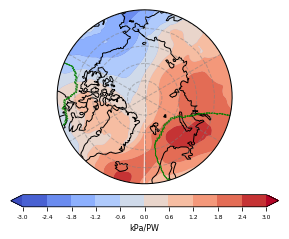

In [7]:
    print ('***********!@#$%^&* Lead/ Lag regression of ERA-Interim !@#$%^&***********')
    print ('======================   AMET + 60N & SLP + winter (DJF)  ======================')
    lag = 0
    AMET_season_series = meta.statistics.operator.seasons(AMET_ERAI[:,:,213],
                                                          span='DJF', Dim_month=True)    
    stat_AMET_ERAI = meta.statistics.operator(AMET_season_series[:])
    stat_AMET_ERAI.anomaly(Dim_month=False)
    stat_AMET_ERAI.detrend()
    stat_AMET_ERAI.lowpass(window=15, obj='detrend')
    SLP_season_series = meta.statistics.operator.seasons(SLP_ERAI[:],
                                                         span=lag_winter[lag])
    stat_SLP_ERAI = meta.statistics.operator(SLP_season_series[:])
    stat_SLP_ERAI.anomaly(Dim_month=False)
    stat_SLP_ERAI.detrend()
    stat_SLP_ERAI.lowpass(window=15, obj='detrend')

    k, r, p = meta.statistics.operator.linearRegress(stat_AMET_ERAI._lowpass,
                                                     stat_SLP_ERAI._lowpass)
    # regression for t-test value based on real degree of freedom
    _, _, p_real = meta.statistics.operator.linearRegress(stat_AMET_ERAI._detrend,
                                                          stat_SLP_ERAI._detrend)  
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    ticks = np.linspace(-3.0,3.0,11)
    #ticks = np.linspace(-0.6,0.6,13)
    #ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    label = 'kPa/PW'
    meta.visualizer.plots.geograph(latitude_fields_ERAI, longitude_fields_ERAI, k/1000, p_real,
                                   label, ticks, os.path.join(output_path, 'ERA-Interim','season',
                                   'spatial_ERAI_AMET_60N_lag_{}_ERAI_SLP_DJF_interannual.png'.format(lag)),
                                   boundary='polarcap', ttest='line')

*******************  postprocess with statistical tool  *********************
***********!@#$%^&* Lead/ Lag regression of ERA-Interim !@#$%^&***********
======================   AMET + 60N & SIC +winter (DJF)  ======================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


/home/ESLT0068/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'linestyle'
  s)


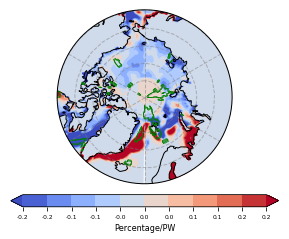

In [8]:
    print ('*******************  postprocess with statistical tool  *********************')
    print ('***********!@#$%^&* Lead/ Lag regression of ERA-Interim !@#$%^&***********')
    print ('======================   AMET + 60N & SIC +winter (DJF)  ======================')
    lag = 0
    AMET_season_series = meta.statistics.operator.seasons(AMET_ERAI[:,:,213],
                                                          span='DJF', Dim_month=True)    
    stat_AMET_ERAI = meta.statistics.operator(AMET_season_series[2:-1])
    stat_AMET_ERAI.anomaly(Dim_month=False)
    stat_AMET_ERAI.detrend()
    stat_AMET_ERAI.lowpass(window=15, obj='detrend')
    SIC_season_series = meta.statistics.operator.seasons(SIC_ERAI[:],
                                                         span=lag_winter[lag])    
    stat_SIC_ERAI = meta.statistics.operator(SIC_season_series[3:])
    stat_SIC_ERAI.anomaly(Dim_month=False)
    stat_SIC_ERAI.detrend()
    stat_SIC_ERAI.lowpass(window=15, obj='detrend')
    k, r, p = meta.statistics.operator.linearRegress(stat_AMET_ERAI._lowpass,
                                                     stat_SIC_ERAI._lowpass)
    _, _, p_real = meta.statistics.operator.linearRegress(stat_AMET_ERAI._detrend,
                                                          stat_SIC_ERAI._detrend)  
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    ticks = np.linspace(-0.20,0.20,11)
    #ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    label = 'Percentage/PW'
    meta.visualizer.plots.geograph(latitude_fields_ERAI, longitude_fields_ERAI,
                                   k, p_real, label, ticks,
                                   os.path.join(output_path, 'ERA-Interim', 'season',
                                   'spatial_ERAI_AMET_60N_lag_{}_ERAI_SIC_DJF_interannual.png'.format(lag)),
                                   boundary='polarcap', ttest='line')
    #np.ma.masked_where(SIC_ERAI_mask[:],k)

***********!@#$%^&* Lead/ Lag regression of ERA-Interim !@#$%^&***********
======================   AMET + 60N & T2M + winter (DJF)  ======================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


/home/ESLT0068/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'linestyle'
  s)


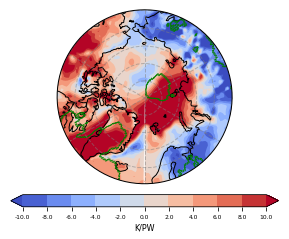

In [9]:
    print ('***********!@#$%^&* Lead/ Lag regression of ERA-Interim !@#$%^&***********')
    print ('======================   AMET + 60N & T2M + winter (DJF)  ======================')
    lag = 0
    AMET_season_series = meta.statistics.operator.seasons(AMET_ERAI[:,:,213],
                                                          span='DJF', Dim_month=True)    
    stat_AMET_ERAI = meta.statistics.operator(AMET_season_series[2:-1])
    stat_AMET_ERAI.anomaly(Dim_month=False)
    stat_AMET_ERAI.detrend()
    stat_AMET_ERAI.lowpass(window=15, obj='detrend')
    T2M_season_series = meta.statistics.operator.seasons(T2M_ERAI[:],
                                                         span=lag_winter[lag], Dim_month=True)
    stat_T2M_ERAI = meta.statistics.operator(T2M_season_series[3:])
    stat_T2M_ERAI.anomaly(Dim_month=False)
    stat_T2M_ERAI.detrend()
    stat_T2M_ERAI.lowpass(window=15, obj='detrend')

    k, r, p = meta.statistics.operator.linearRegress(stat_AMET_ERAI._lowpass,
                                                     stat_T2M_ERAI._lowpass)
    # regression for t-test value based on real degree of freedom
    _, _, p_real = meta.statistics.operator.linearRegress(stat_AMET_ERAI._detrend,
                                                          stat_T2M_ERAI._detrend)  
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    ticks = np.linspace(-10,10,11)
    #ticks = np.linspace(-0.6,0.6,13)
    #ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    label = 'K/PW'
    meta.visualizer.plots.geograph(latitude_fields_ERAI, longitude_fields_ERAI, k, p_real,
                                   label, ticks, os.path.join(output_path, 'ERA-Interim', 'season',
                                   'spatial_ERAI_AMET_60N_lag_{}_ERAI_T2M_DJF_interannual.png'.format(lag)),
                                   boundary='polarcap', ttest='line')

In [10]:
    print ('***********!@#$%^&* Lead/ Lag regression of MERRA2 !@#$%^&***********')
    print ('======================   AMET + 60N & SLP + winter (DJF)  ======================')
    lag = 0
    AMET_season_series = meta.statistics.operator.seasons(AMET_MERRA2[:,:,300],
                                                          span='DJF', Dim_month=True)    
    stat_AMET_MERRA2 = meta.statistics.operator(AMET_season_series[:])
    stat_AMET_MERRA2.anomaly(Dim_month=False)
    stat_AMET_MERRA2.detrend()
    stat_AMET_MERRA2.lowpass(window=3, obj='detrend')
    SLP_season_series = meta.statistics.operator.seasons(SLP_MERRA2[:],
                                                         span=lag_winter[lag],Dim_month=True)
    stat_SLP_MERRA2 = meta.statistics.operator(SLP_season_series[:])
    stat_SLP_MERRA2.anomaly(Dim_month=False)
    stat_SLP_MERRA2.detrend()
    stat_SLP_MERRA2.lowpass(window=3, obj='detrend')

    k, r, p = meta.statistics.operator.linearRegress(stat_AMET_MERRA2._lowpass,
                                                     stat_SLP_MERRA2._lowpass)
    # regression for t-test value based on real degree of freedom
    _, _, p_real = meta.statistics.operator.linearRegress(stat_AMET_MERRA2._detrend,
                                                          stat_SLP_MERRA2._detrend)  
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    ticks = np.linspace(-0.5,0.5,11)
    #ticks = np.linspace(-0.6,0.6,13)
    #ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    label = 'kPa/PW'
    meta.visualizer.plots.geograph(latitude_fields_MERRA2, longitude_fields_MERRA2, k/1000, p_real,
                                   label, ticks, os.path.join(output_path, 'MERRA2','season',
                                   'spatial_MERRA2_AMET_60N_lag_{}_MERRA2_SLP_DJF_annual.png'.format(lag)),
                                   boundary='polarcap', ttest='line')

***********!@#$%^&* Lead/ Lag regression of MERRA2 !@#$%^&***********
======================   AMET + 60N & SLP + winter (DJF)  ======================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.


ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [30]:
    print(stat_AMET_MERRA2._lowpass.shape)
    print(stat_SLP_MERRA2._lowpass.shape)

(106,)
(109, 61, 576)


*******************  postprocess with statistical tool  *********************
***********!@#$%^&* Lead/ Lag regression of MERRA2 !@#$%^&***********
======================   AMET + 60N & SIC +winter (DJF)  ======================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


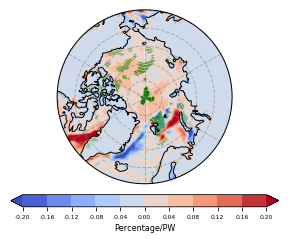

In [26]:
    print ('*******************  postprocess with statistical tool  *********************')
    print ('***********!@#$%^&* Lead/ Lag regression of MERRA2 !@#$%^&***********')
    print ('======================   AMET + 60N & SIC +winter (DJF)  ======================')
    lag = 1
    AMET_season_series = meta.statistics.operator.seasons(AMET_MERRA2[:,:,300],
                                                          span='DJF', Dim_month=True)    
    stat_AMET_MERRA2 = meta.statistics.operator(AMET_season_series[2:-1])
    stat_AMET_MERRA2.anomaly(Dim_month=False)
    stat_AMET_MERRA2.detrend()
    stat_AMET_MERRA2.lowpass(window=15, obj='detrend')
    SIC_season_series = meta.statistics.operator.seasons(SIC_MERRA2[:],
                                                         span=lag_winter[lag], Dim_month=True)    
    stat_SIC_MERRA2 = meta.statistics.operator(SIC_season_series[3:])
    stat_SIC_MERRA2.anomaly(Dim_month=False)
    stat_SIC_MERRA2.detrend()
    stat_SIC_MERRA2.lowpass(window=15, obj='detrend')
    k, r, p = meta.statistics.operator.linearRegress(stat_AMET_MERRA2._lowpass,
                                                     stat_SIC_MERRA2._lowpass)
    _, _, p_real = meta.statistics.operator.linearRegress(stat_AMET_MERRA2._detrend,
                                                          stat_SIC_MERRA2._detrend)  
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    ticks = np.linspace(-0.20,0.20,11)
    #ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    label = 'Percentage/PW'
    meta.visualizer.plots.geograph(latitude_fields_MERRA2, longitude_fields_MERRA2,
                                   k, p_real,
                                   label, ticks, os.path.join(output_path, 'MERRA2', 'season',
                                   'spatial_MERRA2_AMET_60N_lag_{}_MERRA2_SIC_DJF_interannual.png'.format(lag)),
                                   boundary='polarcap', ttest='line')
    #np.ma.masked_where(SST_MERRA2_mask[:],k)

***********!@#$%^&* Lead/ Lag regression of MERRA2 !@#$%^&***********
======================   AMET + 60N & T2M + winter (DJF)  ======================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


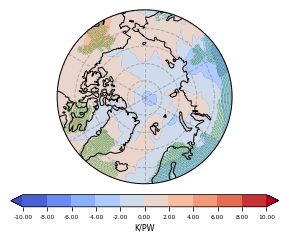

In [35]:
    print ('***********!@#$%^&* Lead/ Lag regression of MERRA2 !@#$%^&***********')
    print ('======================   AMET + 60N & T2M + winter (DJF)  ======================')
    lag = 1
    AMET_season_series = meta.statistics.operator.seasons(AMET_MERRA2[:,:,300],
                                                          span='DJF', Dim_month=True)    
    stat_AMET_MERRA2 = meta.statistics.operator(AMET_season_series[2:-1])
    stat_AMET_MERRA2.anomaly(Dim_month=False)
    stat_AMET_MERRA2.detrend()
    stat_AMET_MERRA2.lowpass(window=3, obj='detrend')
    T2M_season_series = meta.statistics.operator.seasons(T2M_MERRA2[:],
                                                         span=lag_winter[lag],Dim_month=True)
    stat_T2M_MERRA2 = meta.statistics.operator(T2M_season_series[3:])
    stat_T2M_MERRA2.anomaly(Dim_month=False)
    stat_T2M_MERRA2.detrend()
    stat_T2M_MERRA2.lowpass(window=3, obj='detrend')

    k, r, p = meta.statistics.operator.linearRegress(stat_AMET_MERRA2._lowpass,
                                                     stat_T2M_MERRA2._lowpass)
    # regression for t-test value based on real degree of freedom
    _, _, p_real = meta.statistics.operator.linearRegress(stat_AMET_MERRA2._detrend,
                                                          stat_T2M_MERRA2._detrend)  
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    ticks = np.linspace(-10,10,11)
    #ticks = np.linspace(-0.6,0.6,13)
    #ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    label = 'K/PW'
    meta.visualizer.plots.geograph(latitude_fields_MERRA2, longitude_fields_MERRA2, k, p_real,
                                   label, ticks, os.path.join(output_path, 'MERRA2', 'season',
                                   'spatial_MERRA2_AMET_60N_lag_{}_MERRA2_T2M_DJF_annual.png'.format(lag)),
                                   boundary='polarcap', ttest='line')

***********!@#$%^&* Lead/ Lag regression of JRA55 !@#$%^&***********
======================   AMET + 60N & SLP + winter (DJF)  ======================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


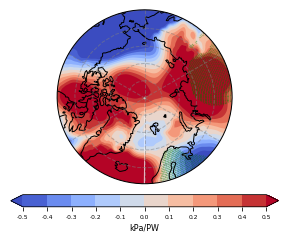

In [57]:
    print ('***********!@#$%^&* Lead/ Lag regression of JRA55 !@#$%^&***********')
    print ('======================   AMET + 60N & SLP + winter (DJF)  ======================')
    lag = 0
    AMET_season_series = meta.statistics.operator.seasons(AMET_JRA55[:,:,267],
                                                          span='DJF', Dim_month=True)    
    stat_AMET_JRA55 = meta.statistics.operator(AMET_season_series[:])
    stat_AMET_JRA55.anomaly(Dim_month=False)
    stat_AMET_JRA55.detrend()
    stat_AMET_JRA55.lowpass(window=15, obj='detrend')
    SLP_season_series = meta.statistics.operator.seasons(SLP_JRA55[:],
                                                         span=lag_winter[lag],Dim_month=True)
    stat_SLP_JRA55 = meta.statistics.operator(SLP_season_series[:])
    stat_SLP_JRA55.anomaly(Dim_month=False)
    stat_SLP_JRA55.detrend()
    stat_SLP_JRA55.lowpass(window=15, obj='detrend')

    k, r, p = meta.statistics.operator.linearRegress(stat_AMET_JRA55._lowpass,
                                                     stat_SLP_JRA55._lowpass)
    # regression for t-test value based on real degree of freedom
    _, _, p_real = meta.statistics.operator.linearRegress(stat_AMET_JRA55._detrend,
                                                          stat_SLP_JRA55._detrend)  
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    ticks = np.linspace(-0.5,0.5,11)
    #ticks = np.linspace(-0.6,0.6,13)
    #ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    label = 'kPa/PW'
    meta.visualizer.plots.geograph(latitude_fields_JRA55, longitude_fields_JRA55, k/1000, p_real,
                                   label, ticks, os.path.join(output_path, 'JRA55', 'season',
                                   'spatial_JRA55_AMET_60N_lag_{}_JRA55_SLP_DJF_interannual.png'.format(lag)),
                                   boundary='polarcap', ttest='line')

*******************  postprocess with statistical tool  *********************
***********!@#$%^&* Lead/ Lag regression of JRA55 !@#$%^&***********
======================   AMET + 60N & SIC +winter (DJF)  ======================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


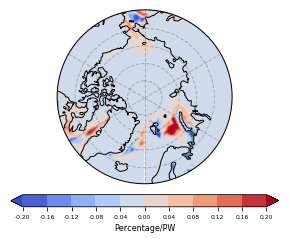

In [32]:
    print ('*******************  postprocess with statistical tool  *********************')
    print ('***********!@#$%^&* Lead/ Lag regression of JRA55 !@#$%^&***********')
    print ('======================   AMET + 60N & SIC +winter (DJF)  ======================')
    lag = 0
    AMET_season_series = meta.statistics.operator.seasons(AMET_JRA55[:,:,267],
                                                          span='DJF', Dim_month=True)    
    stat_AMET_JRA55 = meta.statistics.operator(AMET_season_series[:])
    stat_AMET_JRA55.anomaly(Dim_month=False)
    stat_AMET_JRA55.detrend()
    stat_AMET_JRA55.lowpass(window=3, obj='detrend')
    SIC_season_series = meta.statistics.operator.seasons(SIC_JRA55[:],
                                                         span=lag_winter[lag],Dim_month=True)    
    stat_SIC_JRA55 = meta.statistics.operator(SIC_season_series[:])
    stat_SIC_JRA55.anomaly(Dim_month=False)
    stat_SIC_JRA55.detrend()
    stat_SIC_JRA55.lowpass(window=3, obj='detrend')
    k, r, p = meta.statistics.operator.linearRegress(stat_AMET_JRA55._lowpass,
                                                     stat_SIC_JRA55._lowpass)
    _, _, p_real = meta.statistics.operator.linearRegress(stat_AMET_JRA55._detrend,
                                                          stat_SIC_JRA55._detrend)  
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    ticks = np.linspace(-0.20,0.20,11)
    #ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    label = 'Percentage/PW'
    meta.visualizer.plots.geograph(latitude_fields_JRA55, longitude_fields_JRA55,
                                   k, p_real,
                                   label, ticks, os.path.join(output_path, 'JRA55', 'season',
                                   'spatial_JRA55_AMET_60N_lag_{}_JRA55_SIC_DJF_annual.png'.format(lag)),
                                   boundary='polarcap', ttest='line')
    # np.ma.masked_where(SIC_JRA55_mask[:],k)

***********!@#$%^&* Lead/ Lag regression of JRA55 !@#$%^&***********
======================   AMET + 60N & T2M + winter (DJF)  ======================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 2D field.
One time series is regressed on a 2D field.
Create a NorthPolarStereo view of input fields.
The input fields are originally on geographical grid


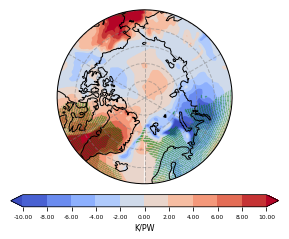

In [30]:
    print ('***********!@#$%^&* Lead/ Lag regression of JRA55 !@#$%^&***********')
    print ('======================   AMET + 60N & T2M + winter (DJF)  ======================')
    lag = 1
    AMET_season_series = meta.statistics.operator.seasons(AMET_JRA55[:,:,267],
                                                          span='DJF', Dim_month=True)    
    stat_AMET_JRA55 = meta.statistics.operator(AMET_season_series[2:-1])
    stat_AMET_JRA55.anomaly(Dim_month=False)
    stat_AMET_JRA55.detrend()
    stat_AMET_JRA55.lowpass(window=15, obj='detrend')
    T2M_season_series = meta.statistics.operator.seasons(T2M_JRA55[:],
                                                         span=lag_winter[lag],Dim_month=True)
    stat_T2M_JRA55 = meta.statistics.operator(T2M_season_series[3:])
    stat_T2M_JRA55.anomaly(Dim_month=False)
    stat_T2M_JRA55.detrend()
    stat_T2M_JRA55.lowpass(window=15, obj='detrend')

    k, r, p = meta.statistics.operator.linearRegress(stat_AMET_JRA55._lowpass,
                                                     stat_T2M_JRA55._lowpass)
    # regression for t-test value based on real degree of freedom
    _, _, p_real = meta.statistics.operator.linearRegress(stat_AMET_JRA55._detrend,
                                                          stat_T2M_JRA55._detrend)  
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    ticks = np.linspace(-10,10,11)
    #ticks = np.linspace(-0.6,0.6,13)
    #ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    label = 'K/PW'
    meta.visualizer.plots.geograph(latitude_fields_JRA55, longitude_fields_JRA55, k, p_real,
                                   label, ticks, os.path.join(output_path, 'JRA55', 'season',
                                   'spatial_JRA55_AMET_60N_lag_{}_JRA55_T2M_DJF_interannual.png'.format(lag)),
                                   boundary='polarcap', ttest='line')

Be cautious about the time across the year! The definition of sign is a bit different from others. Negative means the climatology leads.<br>
If y (fields) leads:<br>
winter (DJF) lag -1 : x[2:] & y[1:-1]<br>
winter (DJF) lag -2 : x[2:] & y[:-2]<br>
winter (DJF) lag -3 : x[2:] & y[:-2]<br>
...<br>
winter (DJF) lag -12 : x[2:] & y[:-2]<br>
...<br>
..........................................<br>
If x (MET) leads:<br>
winter (DJF) lag +1 : x[2:-1] & y[3:]<br>
winter (DJF) lag +2 : x[2:-1] & y[3:]<br>
...<br>
winter (DJF) lag +10 : x[2:-1] & y[3:]<br>
winter (DJF) lag +11 : x[2:-2] & y[4:]<br>
......................................................................................<br>
If y (fields) leads:<br>
summer (JJA) lag -1 : x & y <br>
... <br>
summer (JJA) lag -5 : x & y <br>
summer (JJA) lag -6 : x[3:] & y[2:-1] <br>
summer (JJA) lag -7 : x[3:] & y[1:-2] <br>
summer (JJA) lag -8 : x[3:] & y[:-3] <br>
...<br>
summer (JJA) lag -12 : x[3:] & y[:-3] <br>
..........................................<br>
If x (MET) leads:<br>
summer (JJA) lag +1 : x & y <br>
... <br>
summer (JJA) lag +5 : x[:-1] & y[1:] <br>
summer (JJA) lag +6 : x[:-2] & y[2:] <br>
summer (JJA) lag +7 : x[:-3] & y[3:] <br>
...
summer (JJA) lag +11 : x[:-3] & y[3:] <br>

In [ ]:
    print ('***********!@#$%^&* Lead/ Lag regression of ERA-Interim !@#$%^&***********')
    print ('======================   AMET + 60N & SLP + winter (DJF)  ======================')
    lag = 0
    AMET_season_series = meta.statistics.operator.seasons(AMET_ERAI[:,:,213],
                                                          span='JJA', Dim_month=True)    
    stat_AMET_ERAI = meta.statistics.operator(AMET_season_series[:])
    stat_AMET_ERAI.anomaly(Dim_month=False)
    stat_AMET_ERAI.detrend()
    stat_AMET_ERAI.lowpass(window=15, obj='detrend')
    SLP_season_series = meta.statistics.operator.seasons(SLP_ERAI[:],
                                                         span=lag_winter[lag])
    stat_SLP_ERAI = meta.statistics.operator(SLP_season_series[:])
    stat_SLP_ERAI.anomaly(Dim_month=False)
    stat_SLP_ERAI.detrend()
    stat_SLP_ERAI.lowpass(window=15, obj='detrend')

    k, r, p = meta.statistics.operator.linearRegress(stat_AMET_ERAI._lowpass,
                                                     stat_SLP_ERAI._lowpass)
    # regression for t-test value based on real degree of freedom
    _, _, p_real = meta.statistics.operator.linearRegress(stat_AMET_ERAI._detrend,
                                                          stat_SLP_ERAI._detrend)  
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    ticks = np.linspace(-3.0,3.0,11)
    #ticks = np.linspace(-0.6,0.6,13)
    #ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    label = 'kPa/PW'
    meta.visualizer.plots.geograph(latitude_fields_ERAI, longitude_fields_ERAI, k/1000, p_real,
                                   label, ticks, os.path.join(output_path, 'ERA-Interim', 'season',
                                   'spatial_ERAI_AMET_60N_lag_{}_ERAI_SLP_JJA_interannual.png'.format(lag)),
                                   boundary='polarcap', ttest='line')